## Code produit avec l'article: 
https://medium.com/h7w/implementing-a-variational-autoencoder-with-keras-e19d7140ad90

## On entraîne le modèle sur tous les pixels
### Permet de visualiser les dimensions de la carte latente

In [1]:
from keras.layers import Conv1D, Conv2D, Input, Flatten, Dense, MaxPooling1D, MaxPooling2D, BatchNormalization, Concatenate
from keras.optimizers import Adam
from keras import layers
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from PIL import Image
import copy
import numpy as np
import keras
import os
import re



In [2]:
# Fonction pour calculer les coordonées stéréographiques

def stereo(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    # Projection sur x y
    px = x / (1 + z + 1e-8)
    py = y / (1 + z + 1e-8)
    return px, py

# Importation des images

In [3]:
# Dossier contenant les images
repertoire = "../Render/captures"
img_width, img_height = 30, 30

# Expression pour extraire les infos du nom de fichier
#pattern = re.compile(r"img_tv(\d+)_pv(\d+)_tl(\d+)_pl(\d+)\.png") #all
pattern = re.compile(r"img_tv0_pv0_tl(\d+)_pl(\d+)\.png") #les images avec tv = 45 (la latitude moyenne)

# Stockage des résultats
images_info = []

for nom_fichier in os.listdir(repertoire):
    if nom_fichier.endswith(".png"):
        match = pattern.match(nom_fichier)
        if match:
            tl, pl = match.groups()
            tl, pl = int(tl), int(pl)
            px, py = stereo(np.radians(tl), np.radians(pl)) # Calcul des coordonnées stéréo
            chemin_image = os.path.join(repertoire, nom_fichier)
            image = Image.open(chemin_image)
            w, h = image.size
            left = (w - img_width) / 2
            top = (h - img_height) / 2
            right = (w + img_width) / 2
            bottom = (h + img_height) / 2
            #left, top, right, bottom = int(left), int(top), int(right), int(bottom)
            image = Image.open(chemin_image).convert("RGB").crop((left, top, right, bottom))
            pixels = np.array(image, dtype=np.float32) / 255.0



            images_info.append({
                "tl": tl,
                "pl": pl,
                "px": px,
                "py": py,
                "image": image,
                "pixels": pixels,
            })

# Exemple : affichage d'une info
for info in images_info[:5]:  # juste les 5 premières
    print(f"tl={info['tl']}, pl={info['pl']}, px={info['px']}, py={info['py']}")

tl=75, pl=345, px=0.7411809490095723, py=-0.198598836732448
tl=60, pl=252, px=-0.17841104369713806, py=-0.5490927320369364
tl=75, pl=225, px=-0.5425821122771244, py=-0.5425821122771243
tl=30, pl=120, px=-0.13397459549759358, py=0.23205080632532074
tl=45, pl=0, px=0.4142135599466882, py=0.0


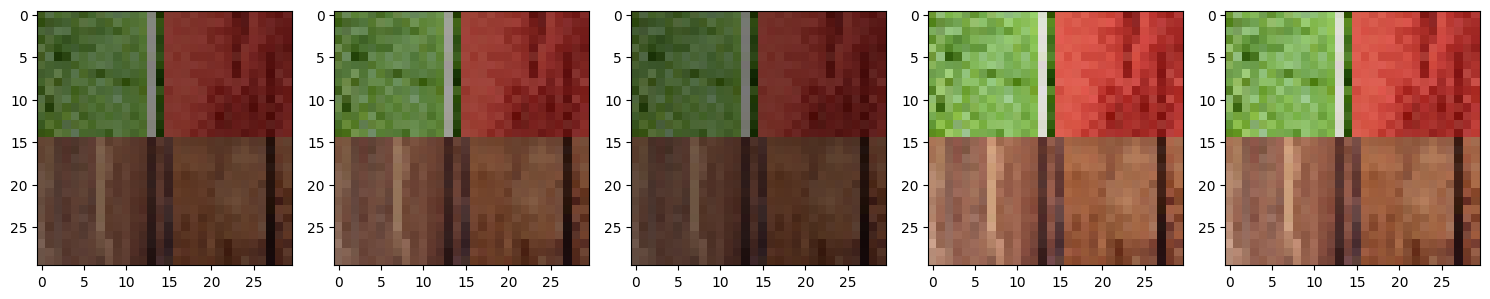

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

# On trie la liste

In [5]:
sorted = copy.deepcopy(images_info)
sorted.sort(key=lambda d: (d["tl"], d["pl"]))

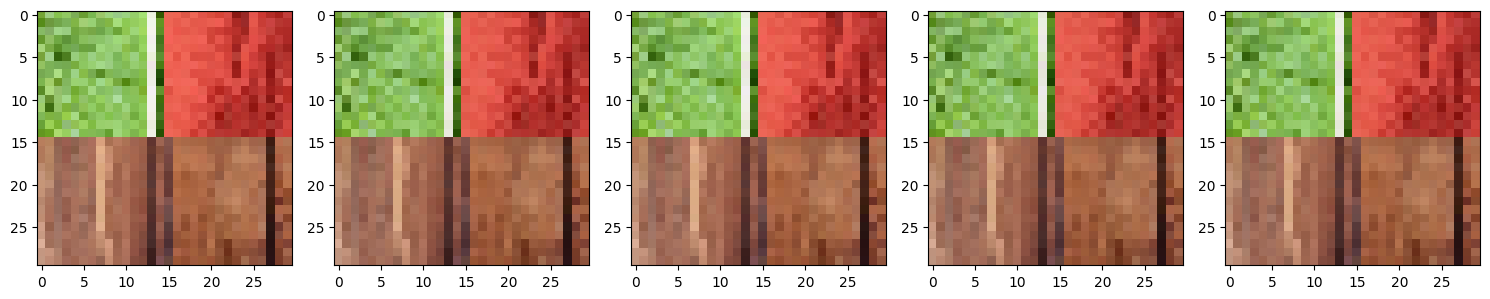

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(sorted[i]['pixels'])
plt.tight_layout()
plt.show()

In [7]:
# On trie par position stereo
images_info.sort(key=lambda d: (d["px"], d["py"]))

In [8]:
print("Premier pixel de la troisième image (R,G,B) :", images_info[2]['pixels'][0][0])
print("Nombre d'images importées:", len(images_info))

Premier pixel de la troisième image (R,G,B) : [0.2509804  0.3529412  0.11372549]
Nombre d'images importées: 81


# Création du modèles

In [10]:
latent_dim = 3 # Dimension du bottleneck
num_channels = 3 # RGB
samples = len(images_info) # Nombre de configuration angulaires
matrix_H = 9
matrix_W = 9

input_shape = (samples, num_channels)

# Definition
i = Input(shape=input_shape, name='encoder_input')

# Bloc 1
x = Conv1D(filters = 64, kernel_size=3, padding='same', activation='relu')(i)
x = BatchNormalization()(x) #weight decay
x = MaxPooling1D(pool_size=2)(x)

# Bloc 2
x = Conv1D(filters = 128, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# Bloc 3
x = Conv1D(filters = 256, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# Bloc 4
x = Conv1D(filters = 512, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)


# Projection
x = Flatten()(x)
latent_output = Dense(latent_dim, name='latent_output')(x)

# Modèle
encoder = Model(inputs=i, outputs=latent_output, name="Encoder")
encoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 81, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 81, 512)        │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 81, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 40, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_output (Dense)           │ (None, 3)              │        61,443 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,611 (268.01 KB)

 Trainable params: 67,587 (264.01 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [11]:
# =================
# Decoder
# =================

# Paramètres
angle_dim = 2  # 2 pour lumière
input_dim = latent_dim + angle_dim  # 8 + 2 = 10

# Entrée
decoder_input = Input(shape=(input_dim,), name='decoder_input')

# 4 couches Fully Connected avec ReLU
x = Dense(106, activation='relu')(decoder_input)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)

# Sortie RGB (3 valeurs)
decoder_output = Dense(3, activation='linear', name='rgb_output')(x)

# Modèle
decoder_model = Model(inputs=decoder_input, outputs=decoder_output, name="Decoder")
decoder_model.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 106)            │           636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rgb_output (Dense)              │ (None, 3)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,983 (136.65 KB)

 Trainable params: 34,983 (136.65 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# =================
# Modele
# =================
view_light_input = Input(shape=(angle_dim,), name='view_light_input')
latent_vector = encoder(i)
decoder_input = Concatenate()([latent_vector, view_light_input])
model_outputs = decoder_model(decoder_input)

model = Model(inputs=[i, view_light_input], outputs=model_outputs, name='Modele')
model.summary()

Model: "Modele"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 81, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder             │ (None, 3)         │     68,611 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_light_input    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5)         │          0 │ Encoder[0][0],    │
│ (Concatenate)       │                   │            │ view_light_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (None, 3)         │     34,983 │ concatenate[0][0] │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,594 (404.66 KB)

 Trainable params: 102,570 (400.66 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [13]:
# --- L2 Loss ---
def custom_reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


# Compilation et entraînement
Sur un seul texel pour commencer

In [14]:
# on prend toutes les images
image_stack = np.stack([info["pixels"] for info in images_info], axis=0)
# image_stack.shape = (N_images, height, width, 3)

In [15]:
image_stack.shape

(81, 30, 30, 3)

In [16]:
# on fait de même avec les angles
tl_stack = np.stack([info["tl"] for info in images_info], axis=0)
pl_stack = np.stack([info["pl"] for info in images_info], axis=0)

# et pour les positions stéréo
px_stack = np.stack([info["px"] for info in images_info], axis=0)
py_stack = np.stack([info["py"] for info in images_info], axis=0)

In [17]:
# Préparation des données

# On prend toutes les ABRDF par texel
num_pixels = img_height*img_width
image_stack_flat = image_stack.reshape((samples, num_pixels, num_channels))

texel_observations = np.zeros((num_pixels, samples, num_channels))
texel_observations = np.transpose(image_stack_flat, (1, 0, 2)) # Pour avoir les informations par pixel, on inverse juste les axes
print("Nouvelle forme:", texel_observations.shape)

Nouvelle forme: (900, 81, 3)


In [18]:
light_dirs = np.stack([px_stack, py_stack], axis=1) # Forme (81, 2)
rep_light_dirs = np.tile(light_dirs, (num_pixels, 1, 1))
target_rgb_train = texel_observations  # (900, 81, 3)

texel_observations.shape, rep_light_dirs.shape, target_rgb_train.shape

((900, 81, 3), (900, 81, 2), (900, 81, 3))

In [19]:
reshaped_input = np.repeat(texel_observations, samples, axis=0)
# Nouvelle forme: (num_pixels * samples, 81, 3)

reshaped_light_dirs = rep_light_dirs.reshape(-1, 2)
# Nouvelle forme: (num_pixels * samples, 2)

reshaped_target_rgb = target_rgb_train.reshape(-1, 3)
# Nouvelle forme: (num_pixels * samples, 3)

reshaped_input.shape, reshaped_light_dirs.shape, reshaped_target_rgb.shape

((72900, 81, 3), (72900, 2), (72900, 3))

# Pre train avant d'utiliser les valeurs de shapley

In [20]:
custom_optimizer = Adam(learning_rate=0.001) # Adam est une version améliorée de la descente de gradient stochastique, par défaut on avait 0.001
model.compile(custom_optimizer, loss=lambda y_true, y_pred: custom_reconstruction_loss(y_true, y_pred))

history = model.fit(
    [reshaped_input, reshaped_light_dirs], # Keras gère le batch_size automatiquement
    reshaped_target_rgb,
    epochs=30,
    batch_size=5, # Keras va prendre 5 pixels à la fois et les passer à l'encodeur/décodeur
    validation_split=0.2
)


Epoch 1/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.0036 - val_loss: 1.9416e-04
Epoch 2/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 4.0861e-04 - val_loss: 2.4478e-04
Epoch 3/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 1.7012e-04 - val_loss: 1.6852e-04
Epoch 4/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 1.1633e-04 - val_loss: 1.5562e-04
Epoch 5/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 9.2688e-05 - val_loss: 2.4129e-04
Epoch 6/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 6.5658e-05 - val_loss: 1.4191e-04
Epoch 7/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 5.6988e-05 - val_loss: 1.8094e-04
Epoch 8/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 5.2432e-05 - val_loss: 9.5010e-05
Epoch 9/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 9.9980e-05 - val_loss: 2.5261e-04
Epoch 10/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 4.8684e-05 - val_loss: 1.2143e-04
Epoch 11/30
1

dict_keys(['loss', 'val_loss'])


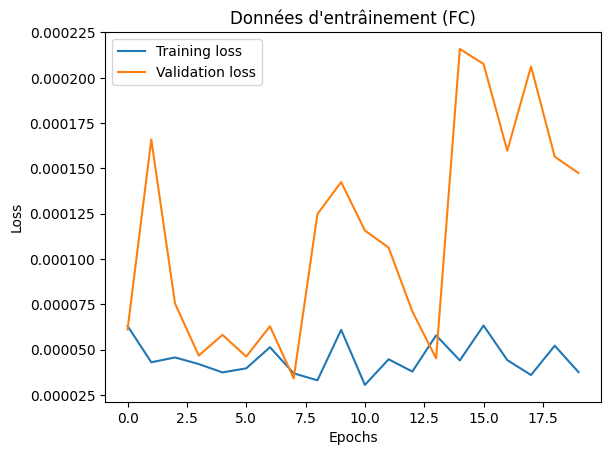

In [21]:
# Evaluer l'apprentissage d'un modèle --Code: Patrick Reuter--
def montrerCourbesApprentissage(history):
    #list all data in history
    print(history.history.keys())

    plt.plot(history.history['loss'][10:], label="Training loss")
    plt.plot(history.history['val_loss'][10:], label="Validation loss")

    plt.title("Données d'entrâinement (FC)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

montrerCourbesApprentissage(history)

# On enregistre le modèle

In [22]:
enco_save_path = os.path.join('modeles/', 'my_enco_model_2_neu.keras')
encoder.save(enco_save_path)


In [23]:
deco_save_path = os.path.join('modeles/', 'my_deco_model_2_neu.keras')
decoder_model.save(deco_save_path)

In [24]:
enco_save_path = os.path.join('modeles/', 'my_enco_model_2_neu.keras')
deco_save_path = os.path.join('modeles/', 'my_deco_model_2_neu.keras')

pre = keras.models.load_model(enco_save_path)
post = keras.models.load_model(deco_save_path)

# Prédicitions sur un pixel

In [25]:
lum_index = 3
pixel_index = 0
light_direction =light_dirs[lum_index]

latent_vector = encoder.predict(reshaped_input)[pixel_index]  # (8,)

# Prédire pour une direction spécifique (par exemple view_light_train[0])
decoder_input = np.concatenate([latent_vector, light_direction])[np.newaxis, :]
predicted_rgb = decoder_model.predict(decoder_input)  # (1, 3)
print("Predicted RGB:", predicted_rgb, "Original", target_rgb_train[pixel_index, lum_index])

2279/2279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted RGB: [[0.25091365 0.35844058 0.11312616]] Original [0.25490198 0.36078432 0.11764706]


In [26]:
lum_index = 3
pixel_index = 0
light_direction =light_dirs[lum_index]

latent_vector = pre.predict(reshaped_input)[pixel_index]  # (8,)

# Prédire pour une direction spécifique (par exemple view_light_train[0])
decoder_input = np.concatenate([latent_vector, light_direction])[np.newaxis, :]
predicted_rgb = post.predict(decoder_input)  # (1, 3)
print("Predicted RGB:", predicted_rgb, "Original", target_rgb_train[pixel_index, lum_index])

2279/2279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted RGB: [[0.25091365 0.35844058 0.11312616]] Original [0.25490198 0.36078432 0.11764706]


# Génération de la carte latente

In [27]:
encoder_input_for_all_pixels = texel_observations # Shape: (num_pixels, 81, 3)

# L'encodeur prendra (num_pixels, 81, 3) et produira (num_pixels, latent_dim)
all_latent_vectors = pre.predict(encoder_input_for_all_pixels, verbose=1)
latent_map = all_latent_vectors.reshape((img_height, img_width, latent_dim))
print(f"Forme de la carte latente: {latent_map.shape}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Forme de la carte latente: (30, 30, 3)


In [30]:
def show_comparaison(latent_map, choose_decoder_model, light_direction_2d, ground_truth_image):
    H, W, latent_dim = latent_map.shape
    num_pixels = H * W

    # Préparer l'entrée du décodeur pour tous les pixels
    latent_flat = latent_map.reshape(-1, latent_dim)  # (H*W, latent_dim)

    # Répéter la direction de lumière pour qu'elle corresponde à chaque pixel
    light_dir_repeated = np.repeat(light_direction_2d[np.newaxis, :], num_pixels, axis=0)

    # Concaténer le vecteur latent de chaque pixel avec la direction de lumière répétée
    decoder_input_combined = np.concatenate([latent_flat, light_dir_repeated], axis=1) # (H*W, latent_dim + angle_dim)


    # Prédiction par le décodeur
    predicted_rgb_flat = choose_decoder_model.predict(decoder_input_combined, verbose=0)  # (H*W, 3)
    predicted_image = predicted_rgb_flat.reshape(H, W, 3) # (H, W, 3)

    # Calcul de la différence absolue
    mse = np.mean(np.square(predicted_image - ground_truth_image))
    diff_image = np.abs(predicted_image - ground_truth_image)


    
    # Normalisation pour l'affichage et affichage
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    display_predicted = np.clip(predicted_image, 0, 1)
    display_ground_truth = np.clip(ground_truth_image, 0, 1)
    display_diff_image = np.clip(diff_image, 0, 1)
    
    # Affichage des images
    axs[0].imshow(display_predicted)
    axs[0].set_title("Image prédite")
    axs[0].axis('off')

    axs[1].imshow(display_ground_truth)
    axs[1].set_title("Image réelle")
    axs[1].axis('off')

    axs[2].imshow(display_diff_image)
    axs[2].set_title(f"Différence absolue (MSE: {mse:.5f})")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

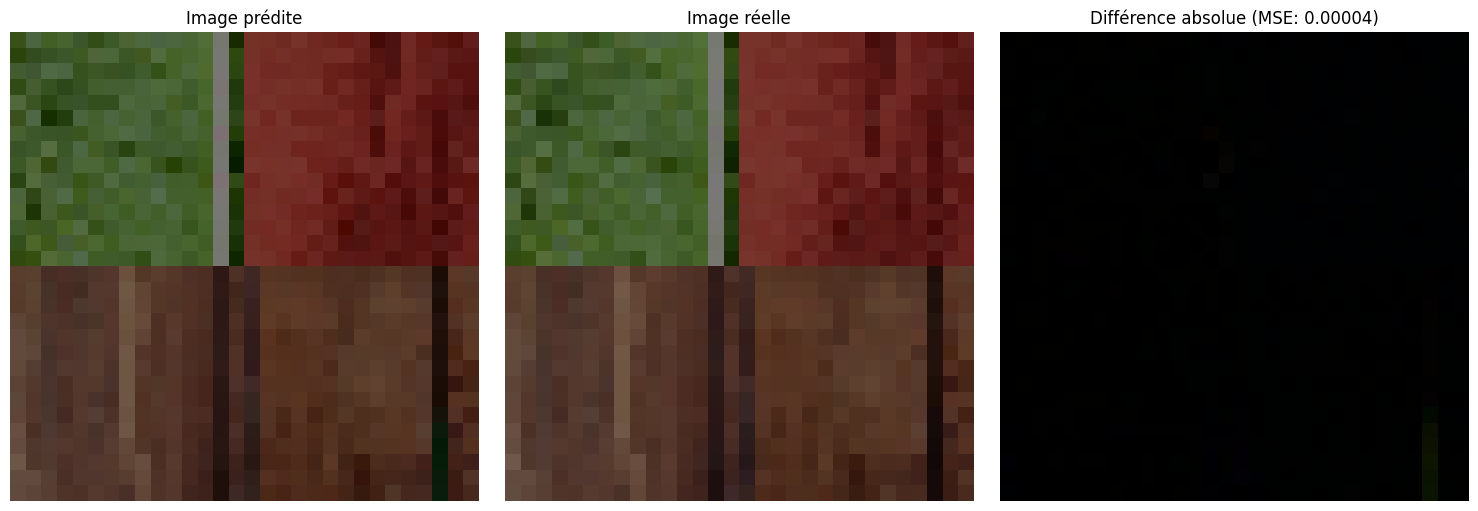

In [33]:
config = 76

angle_to_predict = light_dirs[config]
base_image = image_stack[config]

show_comparaison(latent_map, post, angle_to_predict, base_image)

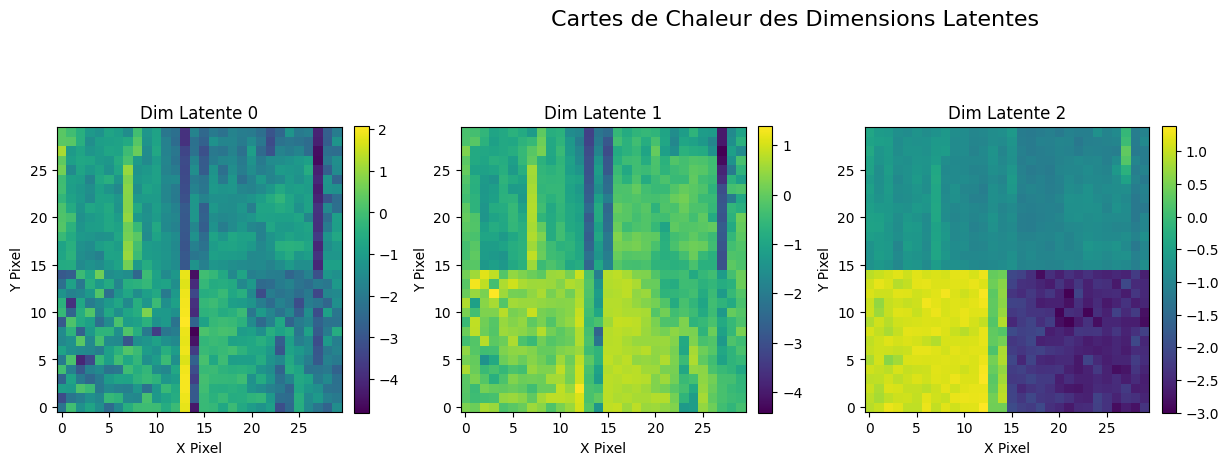

In [34]:
# HEAT MAP

ncols = 4

# Calcule le nombre de lignes nécessaires
nrows = (latent_dim + ncols - 1) // ncols # Division entière avec plafond

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 5 * nrows))

# Aplatir le tableau d'axes pour itérer facilement, quelle que soit la forme (1D ou 2D)
axes = axes.flatten()

for i in range(latent_dim):
    ax = axes[i]
    # Afficher la i-ème dimension latente comme une image 2D
    im = ax.imshow(latent_map[:, :, i], cmap='viridis', origin='lower')
    ax.set_title(f'Dim Latente {i}')
    ax.set_xlabel('X Pixel')
    ax.set_ylabel('Y Pixel')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) # Ajuster la barre de couleur

# Masquer les subplots vides si latent_dim n'est pas un multiple de ncols
for j in range(latent_dim, len(axes)):
    fig.delaxes(axes[j]) # Supprime les axes vides

plt.tight_layout()
plt.suptitle('Cartes de Chaleur des Dimensions Latentes', y=1.02, fontsize=16) # y=1.02 pour laisser de la place au titre principal
plt.show()

## On peut essayer le TSNE

Forme des données pour t-SNE: (900, 3)
Calcul de t-SNE...


/Users/sebych/miniforge3/envs/MLStuff/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE calculé en 2.16 secondes.
Forme des données après t-SNE: (900, 2)


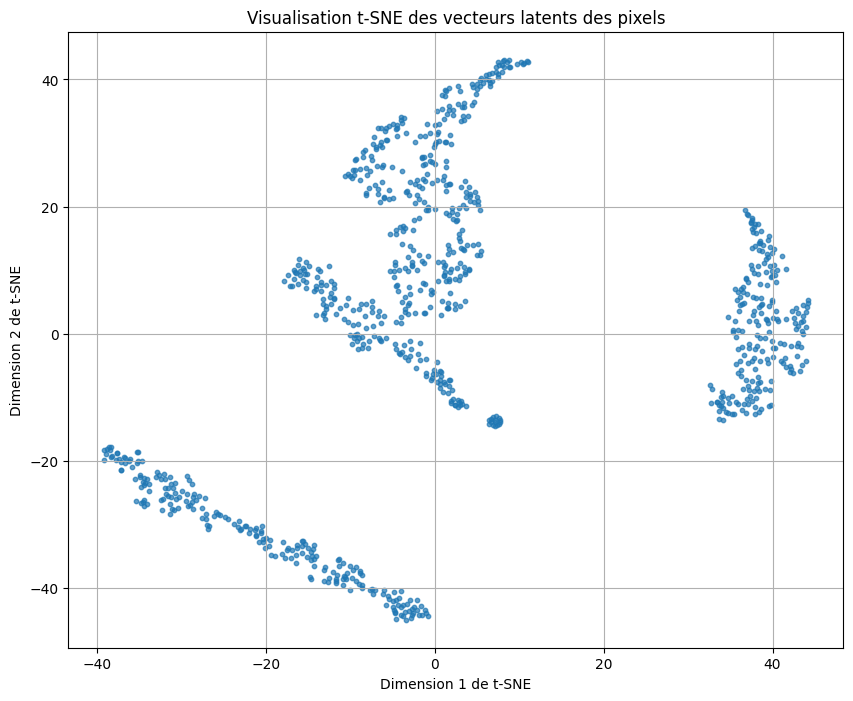

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time

H, W, latent_dim = latent_map.shape
num_pixels = H * W

# Aplatir la carte latente pour obtenir tous les vecteurs latents de pixels
latent_map.reshape(-1, latent_dim) #va transformer (H, W, latent_dim) en (H*W, latent_dim)
latent_vectors_flat = latent_map.reshape(num_pixels, latent_dim)

print(f"Forme des données pour t-SNE: {latent_vectors_flat.shape}")

# - n_components: la dimension de l'espace de sortie (généralement 2 pour la visualisation 2D)
# - perplexity: mesure l'équilibre entre l'attention portée aux voisins locaux et globaux (valeur typique entre 5 et 50)
# - n_iter: nombre maximum d'itérations
# - learning_rate: taux d'apprentissage de l'optimisation
# - random_state: pour la reproductibilité des résultats

print("Calcul de t-SNE...")
start_time = time.time()

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate=200, random_state=42)

# Effectuer la réduction de dimensionnalité
# Le résultat 'latent_2d' aura la forme (num_pixels, 2)
latent_2d = tsne.fit_transform(latent_vectors_flat)

end_time = time.time()
print(f"t-SNE calculé en {end_time - start_time:.2f} secondes.")
print(f"Forme des données après t-SNE: {latent_2d.shape}")

# Visualisation des résultats t-SNE

plt.figure(figsize=(10, 8))

# Chaque point dans 'latent_2d' représente un pixel.
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=10, alpha=0.7) # 's' est la taille des points, 'alpha' est la transparence

plt.title("Visualisation t-SNE des vecteurs latents des pixels")
plt.xlabel("Dimension 1 de t-SNE")
plt.ylabel("Dimension 2 de t-SNE")
plt.grid(True)
plt.show()

# TSNE version avec les pixels labelisés
#### On peut faire un image ou on a du bois, du métal, de la céramique, et voir si notre réseau à réussi à capter ces structures

In [35]:
material_labels_map = np.zeros((img_height, img_width), dtype=int)

material_labels_map[0:15, 0:15] = 1 # Zone supérieure gauche: Textile (Label 1)
material_labels_map[0:15, 15:30] = 2 # Zone supérieure droite: Végétal (Label 2)
material_labels_map[15:30, :] = 0 # Zone inférieure: Bois (Label 0)

In [36]:
# Aplatir les labels des matériaux
material_labels_flat = material_labels_map.flatten() # Forme (H*W,)
print(f"Forme des labels aplatis: {material_labels_flat.shape}")

Forme des labels aplatis: (900,)


Forme des données pour t-SNE: (900, 3)
Calcul de t-SNE... Cela peut prendre un certain temps pour de grandes quantités de données.


/Users/sebych/miniforge3/envs/MLStuff/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE calculé en 1.98 secondes.
Forme des données après t-SNE: (900, 2)


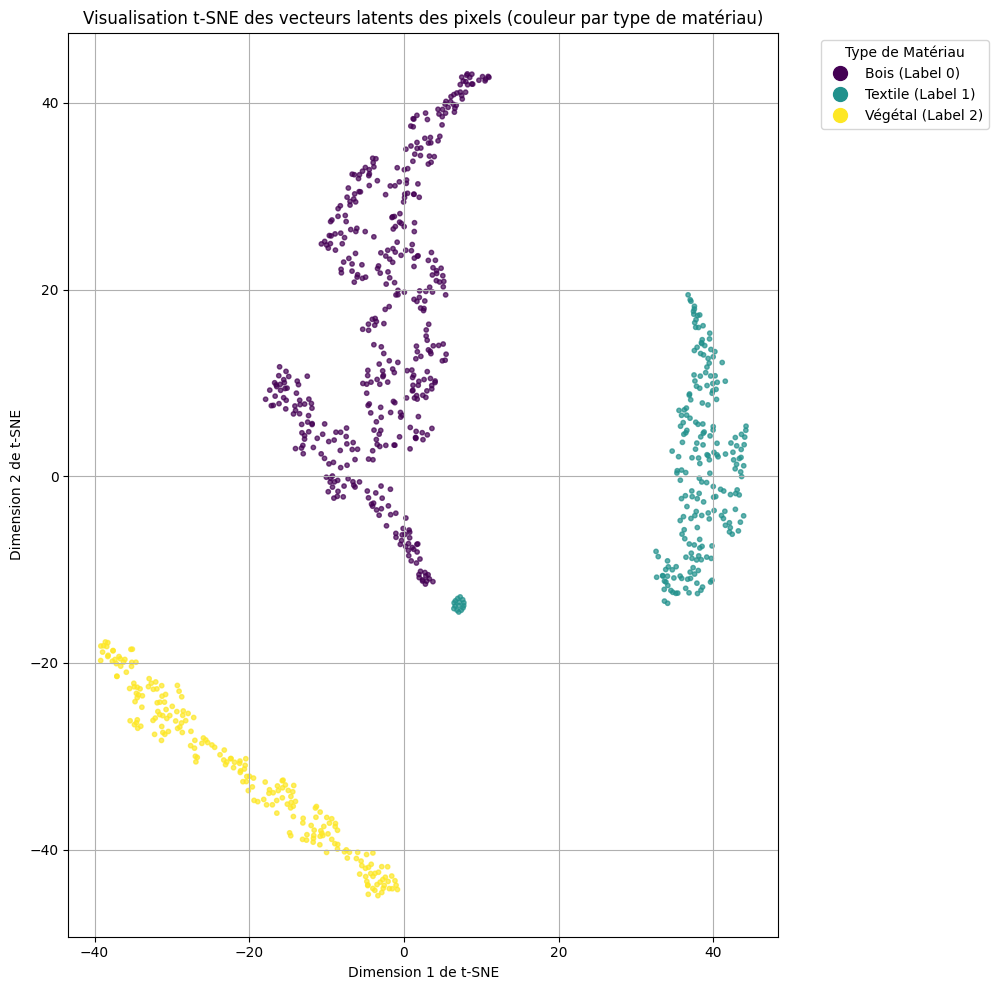

In [36]:
from sklearn.manifold import TSNE
import time

H, W, latent_dim = latent_map.shape
num_pixels = H * W
latent_vectors_flat = latent_map.reshape(num_pixels, latent_dim)

print(f"Forme des données pour t-SNE: {latent_vectors_flat.shape}")

print("Calcul de t-SNE... Cela peut prendre un certain temps pour de grandes quantités de données.")
start_time = time.time()

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate=200, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors_flat)

end_time = time.time()
print(f"t-SNE calculé en {end_time - start_time:.2f} secondes.")
print(f"Forme des données après t-SNE: {latent_2d.shape}")

# Préparation des labels de couleur pour t-SNE 
material_labels_map = np.zeros((H, W), dtype=int)
material_labels_map[0:H//2, 0:W//2] = 1 # Zone supérieure gauche: Textile (Label 1)
material_labels_map[0:H//2, W//2:W] = 2 # Zone supérieure droite: Végétal (Label 2)
material_labels_map[H//2:H, :] = 0 # Zone inférieure: Bois (Label 0)

label_names = {
    0: "Bois (Label 0)",
    1: "Textile (Label 1)",
    2: "Végétal (Label 2)"
}
# colors = ['red', 'green', 'blue'] # Exemples
# cmap = mcolors.ListedColormap(colors)

# Aplatir les labels pour qu'ils correspondent à chaque point de t-SNE
material_labels_flat = material_labels_map.flatten()

# Visualisation des résultats t-SNE avec coloration par label

plt.figure(figsize=(12, 10))

scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                      c=material_labels_flat,
                      cmap='viridis',
                      s=10,
                      alpha=0.7)

plt.title("Visualisation t-SNE des vecteurs latents des pixels (couleur par type de matériau)")
plt.xlabel("Dimension 1 de t-SNE")
plt.ylabel("Dimension 2 de t-SNE")
plt.grid(True)

# Ajouter une légende pour les couleurs
handles = []
labels = []
unique_labels = np.unique(material_labels_flat)
for label_val in unique_labels:
    # Trouver l'indice d'un point avec cette valeur de label
    idx = np.where(material_labels_flat == label_val)[0][0]
    # Créer un point de scatter avec la couleur correspondante pour la légende
    handles.append(plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(label_val)), linestyle='', markersize=10))
    labels.append(label_names.get(label_val, f"Label {label_val}")) # Utilise le nom si dispo, sinon le numéro

plt.legend(handles=handles, labels=labels, title="Type de Matériau", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

Forme des données pour PCA: (900, 3)
Forme des données après PCA: (900, 2)

--- Coefficients des composantes principales (contribution des dimensions originales) ---
Composante Principale 1:
  Dimension originale 2: 0.7597 (Coefficient)
  Dimension originale 0: 0.5177 (Coefficient)
  Dimension originale 1: 0.3935 (Coefficient)
------------------------------
Composante Principale 2:
  Dimension originale 2: 0.6503 (Coefficient)
  Dimension originale 0: -0.6037 (Coefficient)
  Dimension originale 1: -0.4611 (Coefficient)
------------------------------


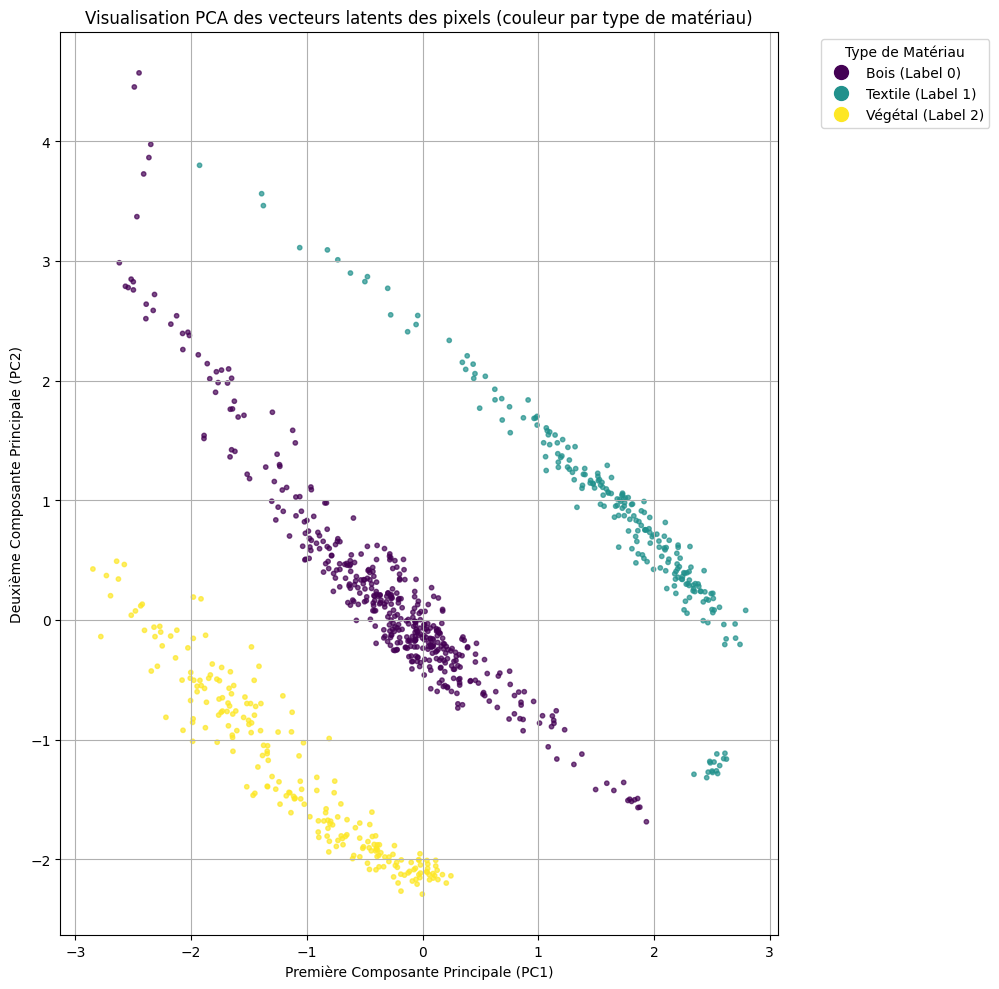


Variance expliquée par PC1: 50.35%
Variance expliquée par PC2: 40.79%
Variance cumulée expliquée par PC1 et PC2: 91.15%


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # Importation de PCA
import time

print(f"Forme des données pour PCA: {latent_vectors_flat.shape}")
# On veut 2 composantes principales pour la visualisation 2D
pca = PCA(n_components=2)
latent_2d_pca = pca.fit_transform(latent_vectors_flat)


print(f"Forme des données après PCA: {latent_2d_pca.shape}")

# Analyse des composantes principales pour voir la dépendance aux dimensions originales
print("\n--- Coefficients des composantes principales (contribution des dimensions originales) ---")
# pca.components_ est une matrice de forme (n_components, n_features)
# Chaque ligne est un vecteur de composante principale
# Chaque colonne correspond à une dimension originale (feature)
for i, pc in enumerate(pca.components_):
    print(f"Composante Principale {i+1}:")
    # Afficher les coefficients les plus importants (en valeur absolue)
    # Tri par ordre décroissant de valeur absolue pour voir les dimensions les plus influentes
    sorted_indices = np.argsort(np.abs(pc))[::-1]
    for idx in sorted_indices[:5]: # Affiche les 5 dimensions originales les plus influentes pour cette PC
        print(f"  Dimension originale {idx}: {pc[idx]:.4f} (Coefficient)")
    print("-" * 30)

# Aplatir les labels pour qu'ils correspondent à chaque point
material_labels_flat = material_labels_map.flatten()

label_names = {
    0: "Bois (Label 0)",
    1: "Textile (Label 1)",
    2: "Végétal (Label 2)"
}


plt.figure(figsize=(12, 10))

scatter = plt.scatter(latent_2d_pca[:, 0], latent_2d_pca[:, 1],
                      c=material_labels_flat,
                      cmap='viridis',
                      s=10,
                      alpha=0.7)

plt.title("Visualisation PCA des vecteurs latents des pixels (couleur par type de matériau)")
plt.xlabel("Première Composante Principale (PC1)")
plt.ylabel("Deuxième Composante Principale (PC2)")
plt.grid(True)

# Ajouter une légende pour les couleurs
handles = []
labels = []
unique_labels = np.unique(material_labels_flat)
for label_val in unique_labels:
    # Trouver l'indice d'un point avec cette valeur de label
    idx = np.where(material_labels_flat == label_val)[0][0]
    # Créer un point de scatter avec la couleur correspondante pour la légende
    handles.append(plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(label_val)), linestyle='', markersize=10))
    labels.append(label_names.get(label_val, f"Label {label_val}"))

plt.legend(handles=handles, labels=labels, title="Type de Matériau", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# Variance expliquée par chaque composante principale
print(f"\nVariance expliquée par PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Variance expliquée par PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"Variance cumulée expliquée par PC1 et PC2: {pca.explained_variance_ratio_.sum()*100:.2f}%")